In [41]:
import glob
import pandas as pd
from Bio import SeqIO
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import subplots_adjust
import matplotlib.ticker as mticks
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams['mathtext.default'] = 'regular'

#### Expression functions

##### Chang et al 2012

In [42]:
def maize_M_BS_chang(ax, orthogroup_fasta_file):
    maize_genes = get_species_genes(orthogroup_fasta_file, 'Zm0', '_', 1)     
    orthogroup_location_dict = {}
    for key in targetp_dict:
        if 'Zm0' in key:
            orthogroup_location_dict[(key.split('_'))[0]] = targetp_dict[key]
    
    chang_df = pd.read_csv("../../DPhil/AILP1_informatics/data/RNA_seq/SRA047278_maize_chang_TPMs_concant_gene_models.csv", delim_whitespace=True)
    chang_df = chang_df.loc[chang_df['Name'].isin(maize_genes)]
    chang_df['M_mean_TPM'] = chang_df[['SRR354212_TPM', 'SRR354213_TPM']].mean(axis = 1) 
    chang_df['BS_mean_TPM'] = chang_df[['SRR354214_TPM', 'SRR354215_TPM']].mean(axis = 1)
    
    rgb_colours = []
    for i, row in chang_df.iterrows():
        rgb_colours.append(gene_colour_dict[row['Name']])
    chang_df['colour'] = rgb_colours
    
   
    chang_df['M_summed_mean'] = chang_df['M_mean_TPM'].groupby(chang_df['colour']).transform('sum')
    chang_df['BS_summed_mean'] = chang_df['BS_mean_TPM'].groupby(chang_df['colour']).transform('sum')
    
    cumval_M = 0
    cumval_BS = 0
    
    sorted_M = chang_df.set_index('Name').sort_values('M_summed_mean')['M_mean_TPM']
    sorted_BS = chang_df.set_index('Name').sort_values('BS_summed_mean')['BS_mean_TPM']
    colours = chang_df.set_index('Name')['colour']
    
    for name, value in sorted_M.iteritems():
        ax.bar('M', value, bottom=cumval_M, label=(orthogroup_location_dict[name] + ' ' + name), color=colours[name])
        cumval_M += value
        
    for name, value in sorted_BS.iteritems():
        ax.bar('BS', value, bottom=cumval_BS, color=colours[name])
        cumval_BS += value
    
    ax.set_ylabel('TPM')
    ax.legend()
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

##### Tausta et al 2012

In [43]:
def maize_M_BS_tausta(ax1, ax2, orthogroup_fasta_file):
    maize_genes = get_species_genes(orthogroup_fasta_file, 'Zm0', '_', 1)     
    orthogroup_location_dict = {}
    for key in targetp_dict:
        if 'Zm0' in key:
            orthogroup_location_dict[(key.split('_'))[0]] = targetp_dict[key]

    tausta_df = pd.read_csv("../../DPhil/AILP1_informatics/data/RNA_seq/SRP035577_merged_TPMs_concated_gene_models.csv", delim_whitespace=True)
    tausta_df = tausta_df.loc[tausta_df['Name'].isin(maize_genes)]

    tausta_df['M_mean_sec_4_TPM'] = tausta_df[['GSM1311350_TPM', 'GSM1311351_TPM']].mean(axis = 1)
    tausta_df['M_mean_sec_9_TPM'] = tausta_df[['GSM1311354_TPM', 'GSM1311355_TPM']].mean(axis = 1) 
    tausta_df['M_mean_sec_14_TPM'] = tausta_df[['GSM1311358_TPM', 'GSM1311359_TPM']].mean(axis = 1) 
    tausta_df['BS_mean_sec_4_TPM'] = tausta_df[['GSM1311348_TPM', 'GSM1311349_TPM']].mean(axis = 1)
    tausta_df['BS_mean_sec_9_TPM'] = tausta_df[['GSM1311352_TPM', 'GSM1311353_TPM']].mean(axis = 1) 
    tausta_df['BS_mean_sec_14_TPM'] = tausta_df[['GSM1311356_TPM', 'GSM1311357_TPM']].mean(axis = 1) 
    
    rgb_colours = []
    for i, row in tausta_df.iterrows():
        rgb_colours.append(gene_colour_dict[row['Name']])
    tausta_df['colour'] = rgb_colours
    
    lines = ["-","--","-.",":"]
    tausta_df.sort_values(by=['colour'], inplace=True)
    tausta_df.reset_index(inplace=True)
    maize_tp_name = []
    line_styles = []
    count = 1
    for i, row in tausta_df.iterrows():
        maize_tp_name.append(orthogroup_location_dict[row['Name']] + ' ' + row['Name'])
        if i == 0:
            line_styles.append(lines[0])
            count = 1
        elif (tausta_df.iloc[i]['colour']) == (tausta_df.iloc[i-1]['colour']):
            line_styles.append(lines[count])
            count+=1
        else:
            line_styles.append(lines[0])
            count = 1

    tausta_df['maize_tp_name'] = maize_tp_name
    tausta_df['line'] = line_styles

    tausta_df = tausta_df.set_index('maize_tp_name')

    tausta_df[['M_mean_sec_4_TPM', 'M_mean_sec_9_TPM', 'M_mean_sec_14_TPM']].transpose().plot(ax=ax1, color=tausta_df['colour'], style=list(tausta_df['line']), linewidth=1.5)
    tausta_df[['BS_mean_sec_4_TPM', 'BS_mean_sec_9_TPM', 'BS_mean_sec_14_TPM']].transpose().plot(ax=ax2, color=tausta_df['colour'], style=list(tausta_df['line']), linewidth=1.5)
    N=3
    ax1.set_xticklabels(['-1', '+4', '+9'])
    ax2.set_xticklabels(['-1', '+4', '+9'])
    ax1.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))
    ax2.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    ax1.set_xlabel('cm from transition zone')
    ax2.set_xlabel('cm from transition zone')

##### Wang et al 2013

In [44]:
def maize_foliar_husk_wang(ax1, ax2, orthogroup_fasta_file):
    maize_genes = get_species_genes(orthogroup_fasta_file, 'Zm0', '_', 1)     
    orthogroup_location_dict = {}
    for key in targetp_dict:
        if 'Zm0' in key:
            orthogroup_location_dict[(key.split('_'))[0]] = targetp_dict[key]

    wang_df = pd.read_csv("../../DPhil/AILP1_informatics/data/RNA_seq/SRP028231_Wang_merged_TPMs_concated_gene_models.csv", delim_whitespace=True)
    wang_df = wang_df.loc[wang_df['Name'].isin(maize_genes)]

    wang_df['F_AM_P1_P2'] = wang_df['SRR942909_TPM']
    wang_df['F_P3_P4'] = wang_df['SRR942915_TPM']
    wang_df['F_P5'] = wang_df['SRR942916_TPM']
    wang_df['F_I'] = wang_df['SRR942911_TPM']
    wang_df['F_E'] = wang_df['SRR942910_TPM']
    wang_df['H_P1_P2'] = wang_df['SRR942912_TPM']
    wang_df['H_P3_P4'] = wang_df['SRR942917_TPM']
    wang_df['H_P5'] = wang_df['SRR942918_TPM']
    wang_df['H_I'] = wang_df['SRR942913_TPM']
    wang_df['H_E'] = wang_df['SRR942914_TPM']

    rgb_colours = []
    for i, row in wang_df.iterrows():
        rgb_colours.append(gene_colour_dict[row['Name']])
    wang_df['colour'] = rgb_colours
    
    lines = ["-","--","-.",":"]
    wang_df.sort_values(by=['colour'], inplace=True)
    wang_df.reset_index(inplace=True)
    maize_tp_name = []
    line_styles = []
    count = 1
    for i, row in wang_df.iterrows():
        maize_tp_name.append(orthogroup_location_dict[row['Name']] + ' ' + row['Name'])
        if i == 0:
            line_styles.append(lines[0])
            count = 1
        elif (wang_df.iloc[i]['colour']) == (wang_df.iloc[i-1]['colour']):
            line_styles.append(lines[count])
            count+=1
        else:
            line_styles.append(lines[0])
            count = 1

    wang_df['maize_tp_name'] = maize_tp_name
    wang_df['line'] = line_styles

    wang_df = wang_df.set_index('maize_tp_name')
    

    wang_df[['H_P1_P2', 'H_P3_P4', 'H_P5', 'H_I', 'H_E']].transpose().plot(ax=ax1, color=wang_df['colour'], style=list(wang_df['line']), linewidth=1.5)
    wang_df[['F_AM_P1_P2', 'F_P3_P4', 'F_P5', 'F_I', 'F_E']].transpose().plot(ax=ax2, color=wang_df['colour'], style=list(wang_df['line']), linewidth=1.5)
    N=5
    ax1.set_xticklabels(['P1-P2', 'P3-P4', 'P5', 'I', 'E'])
    ax2.set_xticklabels(['AM-P2', 'P3-P4', 'P5', 'I', 'E'])
    ax1.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))
    ax2.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    ax1.set_xlabel('Developmental stage')
    ax2.set_xlabel('Developmental stage')

gowick

In [55]:
def flaveria_C3_C4_Gowick(ax, orthogroup_fasta_file):
    arabidopsis_genes = get_species_genes(orthogroup_fasta_file, 'AT', '.', 1)

    orthogroup_location_dict = {}
    for key in targetp_dict:
        if 'AT' in key:
            orthogroup_location_dict[(key.split('.'))[0]] = targetp_dict[key]

    gowick_df = pd.read_csv('../../DPhil/AILP1_informatics/data/RNA_seq/Flaveria_Gowik_Supplemental_Dataset_1-1.csv')
    gowick_df = gowick_df.loc[gowick_df['Locus'].isin(arabidopsis_genes)]
    
    rgb_colours = []
    for i, row in gowick_df.iterrows():
        rgb_colours.append(gene_colour_dict[row['Locus']])
    gowick_df['colour'] = rgb_colours
    
    gowick_df['F_pringlei_summed_rpm'] = gowick_df['F_pringlei_rpm'].groupby(gowick_df['colour']).transform('sum')
    gowick_df['F_robusta_summed_rpm'] = gowick_df['F_robusta_rpm'].groupby(gowick_df['colour']).transform('sum')
    gowick_df['F_ramosissima_summed_rpm'] = gowick_df['F_ramosissima_rpm'].groupby(gowick_df['colour']).transform('sum')
    gowick_df['F_trinervia_summed_rpm'] = gowick_df['F_trinervia_rpm'].groupby(gowick_df['colour']).transform('sum')
    gowick_df['F_bidentis_summed_rpm'] = gowick_df['F_bidentis_rpm'].groupby(gowick_df['colour']).transform('sum')

    cumval_pri = 0
    cumval_rob = 0
    cumval_ram = 0
    cumval_tri = 0
    cumval_bid = 0
    
    sorted_pri = gowick_df.set_index('Locus').sort_values('F_pringlei_summed_rpm')['F_pringlei_rpm']
    sorted_rob = gowick_df.set_index('Locus').sort_values('F_robusta_summed_rpm')['F_robusta_rpm']
    sorted_ram = gowick_df.set_index('Locus').sort_values('F_ramosissima_summed_rpm')['F_ramosissima_rpm']
    sorted_tri = gowick_df.set_index('Locus').sort_values('F_trinervia_summed_rpm')['F_trinervia_rpm']
    sorted_bid = gowick_df.set_index('Locus').sort_values('F_bidentis_summed_rpm')['F_bidentis_rpm']

    colours = gowick_df.set_index('Locus')['colour']

    for name, value in sorted_pri.iteritems():
        ax.bar('F. pringeli\n$C_{3}$', value, bottom=cumval_pri, color=colours[name])
        cumval_pri += value

    for name, value in sorted_rob.iteritems():
        ax.bar('F. robusta\n$C_{3}$', value, bottom=cumval_rob, color=colours[name])
        cumval_rob += value
        
    for name, value in sorted_ram.iteritems():
        ax.bar('F. ramosissima\n$C_{3}$-$C_{4}$', value, bottom=cumval_ram, color=colours[name])
        cumval_ram += value
        
    for name, value in sorted_tri.iteritems():
        ax.bar('F. trinervia\n$C_{4}$', value, bottom=cumval_tri, color=colours[name])
        cumval_tri += value
        
    for name, value in sorted_bid.iteritems():
        ax.bar('F. bidentis\n$C_{4}$', value, bottom=cumval_bid, label=(orthogroup_location_dict[name] + ' ' + name), color=colours[name])
        cumval_bid += value

C3 vs C4 boxplot

In [64]:
def C3_v_C4_boxplot(ax, orthogroup_fasta_file):
    arabidopsis_genes = get_species_genes(orthogroup_fasta_file, 'AT', '.', 1)
    
    #arabidopsis_genes = ['AT5G19140', 'AT5G43830']
    species_info_df = pd.read_csv('../../DPhil/AILP1_informatics/data/C3_v_C4_expression/species_info.csv')
    C3_code_list = ((species_info_df.loc[species_info_df['Photosynthesis'] == 'C3'])['Mature_leaf_library_ID']).dropna().to_list()
    C4_code_list = ((species_info_df.loc[species_info_df['Photosynthesis'] == 'C4'])['Mature_leaf_library_ID']).dropna().to_list()
    NADP_code_list = ((species_info_df.loc[species_info_df['Type'] == 'NADP-ME'])['Mature_leaf_library_ID']).dropna().to_list()
    NAD_code_list = ((species_info_df.loc[species_info_df['Type'] == 'NAD-ME'])['Mature_leaf_library_ID']).dropna().to_list()

    expression_df = pd.read_csv('../../DPhil/AILP1_informatics/data/C3_v_C4_expression/FINAL_results_t10_no_VYNC_new_RBB_sga_assembly_libsize1.csv', skiprows=3)
    expression_df = expression_df.loc[expression_df['Arabidopsis'].isin(arabidopsis_genes)]
    expression_df_summed = expression_df.sum(axis=0, skipna = True)

    C3_expression_list = []
    C4_expression_list =[]
    NADP_expression_list = []
    NAD_expression_list = []
    for code in C3_code_list:
        C3_expression_list.append(expression_df_summed[code])
    for code in C4_code_list:
        C4_expression_list.append(expression_df_summed[code])
    for code in NADP_code_list:
        NADP_expression_list.append(expression_df_summed[code])
    for code in NAD_code_list:
        NAD_expression_list.append(expression_df_summed[code])

    C3_df = pd.DataFrame(columns=['C3'])
    C4_df = pd.DataFrame(columns=['C4'])
    NADP_df = pd.DataFrame(columns=['NADP-ME'])
    NAD_df = pd.DataFrame(columns=['NAD-ME'])

    C3_df['C3'] = C3_expression_list
    C4_df['C4'] = C4_expression_list
    NADP_df['NADP-ME'] = NADP_expression_list
    NAD_df['NAD-ME'] = NAD_expression_list

    C3_df = C3_df.apply(pd.to_numeric, errors='coerce')
    C4_df = C4_df.apply(pd.to_numeric, errors='coerce')
    NADP_df = NADP_df.apply(pd.to_numeric, errors='coerce')
    NAD_df = NAD_df.apply(pd.to_numeric, errors='coerce')

    result_df = pd.concat([C3_df,C4_df, NADP_df, NAD_df], axis=1)
    result_df.boxplot(grid=False)
    ax.set_xticklabels(['$C_{3}$', '$C_{4}$', 'NADP-ME', 'NAD-ME'])

woo et al

In [65]:
def arabidopsis_dev_woo(ax, orthogroup_fasta_file):
    arabidopsis_genes = get_species_genes(orthogroup_fasta_file, 'AT', '.', 1)
    orthogroup_location_dict = {}
    for key in targetp_dict:
        if 'AT' in key:
            orthogroup_location_dict[(key.split('.'))[0]] = targetp_dict[key]

    woo_df = pd.read_csv('../../DPhil/AILP1_informatics/data/RNA_seq/SRP018034_Woo_merged_TPMs_concated_gene_models.csv', delim_whitespace=True)
    woo_df = woo_df.loc[woo_df['Name'].isin(arabidopsis_genes)]
    
    woo_df['4_mean_TPM'] = woo_df[['SRR2079771_TPM', 'SRR2079785_TPM']].mean(axis = 1)
    woo_df['6_mean_TPM'] = woo_df[['SRR2079772_TPM', 'SRR2079786_TPM']].mean(axis = 1)
    woo_df['8_mean_TPM'] = woo_df[['SRR2079773_TPM', 'SRR2079787_TPM']].mean(axis = 1)
    woo_df['10_mean_TPM'] = woo_df[['SRR2079774_TPM', 'SRR2079788_TPM']].mean(axis = 1)
    woo_df['12_mean_TPM'] = woo_df[['SRR2079775_TPM', 'SRR2079789_TPM']].mean(axis = 1)
    woo_df['14_mean_TPM'] = woo_df[['SRR2079776_TPM', 'SRR2079790_TPM']].mean(axis = 1)
    woo_df['16_mean_TPM'] = woo_df[['SRR2079777_TPM', 'SRR2079791_TPM']].mean(axis = 1)
    woo_df['18_mean_TPM'] = woo_df[['SRR2079778_TPM', 'SRR2079792_TPM']].mean(axis = 1)
    woo_df['20_mean_TPM'] = woo_df[['SRR2079779_TPM', 'SRR2079793_TPM']].mean(axis = 1)
    woo_df['22_mean_TPM'] = woo_df[['SRR2079780_TPM', 'SRR2079794_TPM']].mean(axis = 1)
    woo_df['24_mean_TPM'] = woo_df[['SRR2079781_TPM', 'SRR2079795_TPM']].mean(axis = 1)
    woo_df['26_mean_TPM'] = woo_df[['SRR2079781_TPM', 'SRR2079796_TPM']].mean(axis = 1)
    woo_df['28_mean_TPM'] = woo_df[['SRR2079783_TPM', 'SRR2079797_TPM']].mean(axis = 1)
    woo_df['30_mean_TPM'] = woo_df[['SRR2079784_TPM', 'SRR2079798_TPM']].mean(axis = 1)
    
    
    rgb_colours = []
    for i, row in woo_df.iterrows():
        rgb_colours.append(gene_colour_dict[row['Name']])
    woo_df['colour'] = rgb_colours

    lines = ["-","--","-.",":"]
    woo_df.sort_values(by=['colour'], inplace=True)
    woo_df.reset_index(inplace=True)
    gene_tp_name = []
    line_styles = []
    count = 1
    for i, row in woo_df.iterrows():
        gene_tp_name.append(orthogroup_location_dict[row['Name']] + ' ' + row['Name'])
        if i == 0:
            line_styles.append(lines[0])
            count = 1
        elif (woo_df.iloc[i]['colour']) == (woo_df.iloc[i-1]['colour']):
            if count == len(lines):
                count = 0
            line_styles.append(lines[count])
            count+=1
        else:
            line_styles.append(lines[0])
            count = 1
           
    woo_df['gene_tp_name'] = gene_tp_name
    woo_df['line'] = line_styles            
            
    woo_df = woo_df.set_index('gene_tp_name')
    
    woo_df[['4_mean_TPM', '6_mean_TPM', '8_mean_TPM', '10_mean_TPM', '12_mean_TPM', '14_mean_TPM', '16_mean_TPM', '18_mean_TPM',\
            '20_mean_TPM', '22_mean_TPM', '24_mean_TPM', '26_mean_TPM', '28_mean_TPM', '30_mean_TPM'\
           ]].transpose().plot(ax=ax, color=woo_df['colour'], style=list(woo_df['line']), linewidth=1.5)
            
    N=14
    ax.set_xticklabels(['4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30'])
    ax.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#### Other functions

In [66]:
# Fetch the relevant genes from the orthogroup
def get_species_genes(fasta_file, species_string, delimiter, delimiter_position):
    genes = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        if species_string in record.id:
            gene_list = ((record.id).split(delimiter))
            gene = delimiter.join(gene_list[:delimiter_position])
            genes.append(gene)
    return(genes)

In [67]:
# Get the predicted localisations
def make_targetp_dict(orthogroup_targetP_files):
    targetp_df = pd.read_csv(orthogroup_targetP_files, delimiter = '\t')
    targetp_dict1 = pd.Series(targetp_df['loc'].values, index=targetp_df['gene']).to_dict()
    targetp_dict2 = {}
    for key in targetp_dict1:
        if targetp_dict1[key] == 'P':
            targetp_dict2[key] = 'PTS'
        else:
            targetp_dict2[key] = targetp_dict1[key]
    return(targetp_dict2)


In [68]:
def get_new_position(ax, shiftx_dist, shifty_dist):
    original_pos = ax.get_position() # get the original position 
    pos_new = [original_pos.x0 + shiftx_dist, original_pos.y0 + shifty_dist,  original_pos.width, original_pos.height] 
    return(pos_new)

#### Get the data

In [69]:
orthogroup_fasta_file = ('../../DPhil/AILP1_informatics/data/msa_data/Orthogroups/OG0000596.fa')
targetP_file = ('../../DPhil/AILP1_informatics/data/msa_data/targetP_results/OG0000596_targetp2_PTS.txt')
targetp_dict = make_targetp_dict(targetP_file)

In [70]:
# Make colour dict for the genes
clade_1 = ['AT5G43830', 'AT3G22850', 'Zm00001d034433', 'Zm00001d033983']
clade_2 = ['Zm00001d023376', 'Zm00001d052493', 'AT5G19140']
clade_3 = ['AT3G15450', 'AT4G27450', 'Zm00001d026632']

gene_colour_dict = {}
for item in clade_1:
     gene_colour_dict[item] = '#FFCCCC'
for item in clade_2:
    gene_colour_dict[item] = '#CCEEFF'
for item in clade_3:
    gene_colour_dict[item] = '#CCDDAA'

#### Make the plot

/Users/rona/miniconda3/envs/AILP1_informatics/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (31,36) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


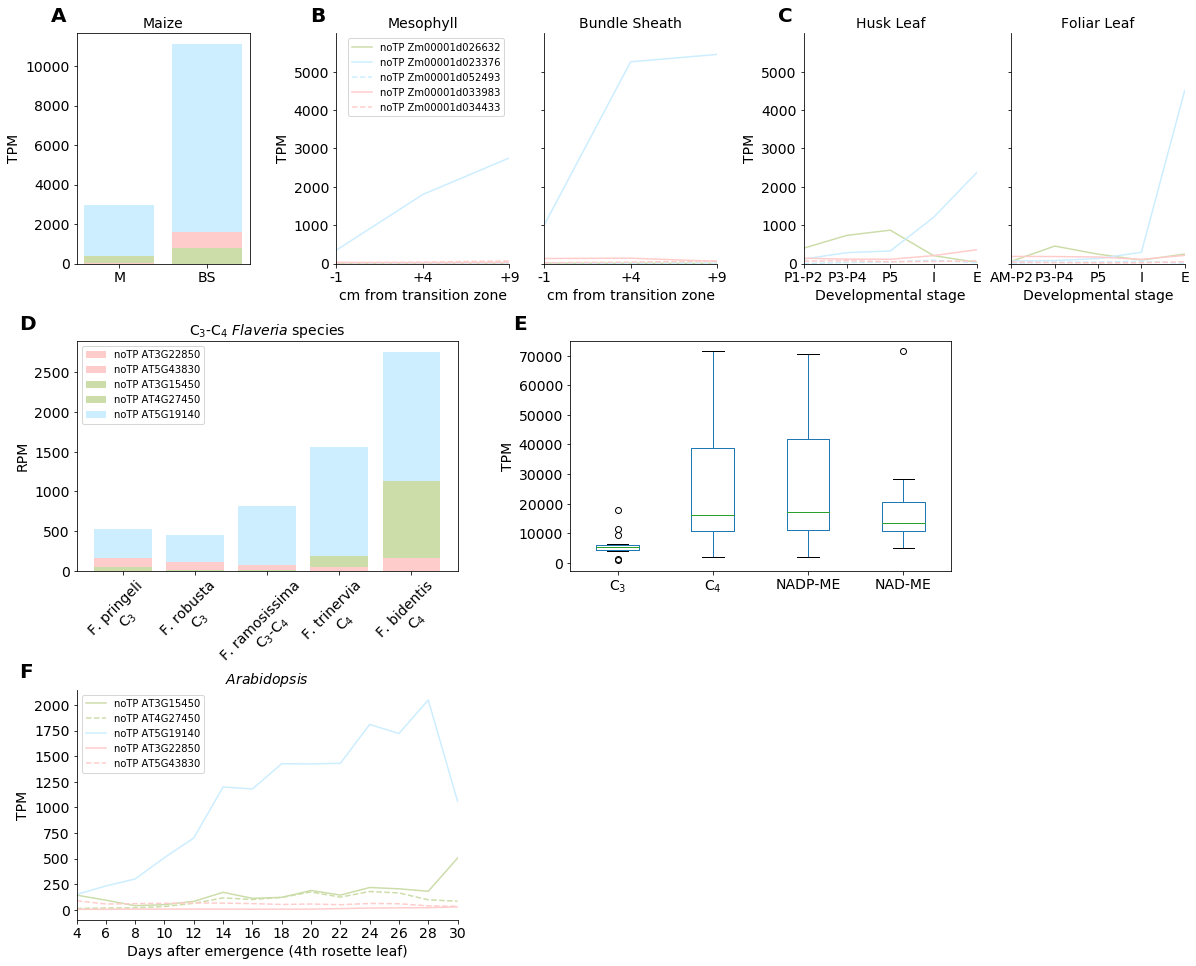

In [83]:
fig_variables = { "legend_font_size": 10, "y_label_font_size": 14, "x_label_font_size": 14, "x_tick_font_size": 14,
                  "y_tick_font_size": 12, "arabidopsis_x_tick_font_size": 12, "title_size": 14, "figsize": (18,14.4), "left": 0.125, 
                  "bottom": 0.1, "right": 0.9, "top": 0.9, "wspace": 0.2, "hspace": 0.60}

fig = plt.figure(constrained_layout=False, figsize=fig_variables['figsize'])
spec = gridspec.GridSpec(ncols=5, nrows=3, figure=fig)

### Panel A ###

ax1 = fig.add_subplot(spec[0,0])

# Chang
maize_M_BS_chang(ax1, orthogroup_fasta_file)
ax1.set_ylabel('TPM', fontsize=fig_variables['y_label_font_size'])
ax1.get_legend().remove()
for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    
ax1.set_title('Maize', size=fig_variables['title_size'])
    

### Panel B ###
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[0, 2])

ax2.set_position(get_new_position(ax2, 0.04, 0))
ax3.set_position(get_new_position(ax3, 0.04, 0))

# Tausta 
maize_M_BS_tausta(ax2, ax3, orthogroup_fasta_file)
ax2.get_legend().remove()
ax2.legend(fontsize=fig_variables['legend_font_size'])
ax2.set_xlabel('cm from transition zone', fontsize=fig_variables['x_label_font_size'])
ax3.set_xlabel('cm from transition zone', fontsize=fig_variables['x_label_font_size'])
ax2.set_ylim(0, 6000)
ax2.set_yticks([0, 1000, 2000, 3000, 4000, 5000])
ax2.set_ylabel('TPM', fontsize=fig_variables['y_label_font_size'])
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])

ax3.get_legend().remove()
ax3.set_ylim(0, 6000)
ax3.set_yticks([0, 1000, 2000, 3000, 4000, 5000])
ax3.tick_params(labelleft=False) 

for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    
ax2.set_title('Mesophyll', size=fig_variables['title_size'])
ax3.set_title('Bundle Sheath', size=fig_variables['title_size'])


### Panel C ###
ax4 = fig.add_subplot(spec[0, 3])
ax5 = fig.add_subplot(spec[0, 4])

ax4.set_position(get_new_position(ax4, 0.08, 0))
ax5.set_position(get_new_position(ax5, 0.08, 0))

# Wang
maize_foliar_husk_wang(ax4, ax5, orthogroup_fasta_file)
ax4.get_legend().remove()
ax4.set_xlabel('Developmental stage', fontsize=fig_variables['x_label_font_size'])
for tick in ax4.xaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
ax4.set_ylim(0, 6000)
ax4.set_yticks([0, 1000, 2000, 3000, 4000, 5000])
for tick in ax4.yaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
ax4.set_ylabel('TPM', fontsize=fig_variables['y_label_font_size'])

ax5.get_legend().remove()
ax5.set_xlabel('Developmental stage', fontsize=fig_variables['x_label_font_size'])
for tick in ax5.xaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
ax5.set_ylim(0, 6000)
ax5.set_yticks([0, 1000, 2000, 3000, 4000, 5000])
ax5.tick_params(labelleft=False) 

ax4.set_title('Husk Leaf', size=fig_variables['title_size'])
ax5.set_title('Foliar Leaf', size=fig_variables['title_size'])

    
#### Panel D ####
# gowick
ax6 = fig.add_subplot(spec[1, 0:2])
ax6.set_position(get_new_position(ax6, 0, -0.03))

flaveria_C3_C4_Gowick(ax6, orthogroup_fasta_file)
ax6.set_ylabel('RPM', fontsize=fig_variables['x_label_font_size'])
ax6.legend(fontsize=fig_variables['legend_font_size'])
for tick in ax6.xaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
for tick in ax6.get_xticklabels():
    tick.set_rotation(45)
for tick in ax6.yaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    
ax6.set_title('$C_{3}$-$C_{4}$ $\it{Flaveria}$ species', size=fig_variables['title_size'])

#### Panel E ####
# boxplot
ax7 = fig.add_subplot(spec[1, 2:4])
ax7.set_position(get_new_position(ax7, 0.06, -0.03))

C3_v_C4_boxplot(ax7, orthogroup_fasta_file)
ax7.set_ylabel('TPM', fontsize=fig_variables['x_label_font_size'])
for tick in ax7.xaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
for tick in ax7.yaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    
#### Panel F ####
# woo
ax8 = fig.add_subplot(spec[2, 0:2])
ax8.set_position(get_new_position(ax8, 0, -0.1))

arabidopsis_dev_woo(ax8, orthogroup_fasta_file)
ax8.set_ylabel('TPM', fontsize=fig_variables['x_label_font_size'])
ax8.set_xlabel('Days after emergence (4th rosette leaf)', fontsize=fig_variables['x_label_font_size'])
ax8.legend(fontsize=fig_variables['legend_font_size'])
for tick in ax8.xaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
for tick in ax8.yaxis.get_major_ticks():
    tick.label.set_fontsize(fig_variables['x_tick_font_size'])
ax8.set_title('$\itArabidopsis$', size=fig_variables['title_size'])
    
labels = ['A', 'B', 'C', 'D', 'E', 'F']
axs = [ax1, ax2, ax4, ax6, ax7, ax8]
for n, ax in enumerate(axs):  
    ax.text(-0.15, 1.05, labels[n], transform=ax.transAxes, 
            size=20, weight='bold')

plt.savefig('../figures/ailp1Expression.pdf', bbox_inches='tight')
    
# subplots_adjust(left=fig_variables['left'], bottom=fig_variables['bottom'], right=fig_variables['right'], top=fig_variables['top'], wspace=fig_variables['wspace'], hspace=fig_variables['hspace'])